# Advanced Approach for Trace Clustering - Tuning

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.utils import io
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import os
import pandas as pd
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
from pm4py.objects.conversion.log import converter as log_converter
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from karateclub.node_embedding.neighbourhood import Walklets
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from umap import UMAP
from ConfigSpace import Categorical, ConfigurationSpace, Float, Integer
from ConfigSpace.conditions import InCondition
from smac import Callback
from smac import HyperparameterOptimizationFacade, Scenario, BlackBoxFacade
from practical.ProcessMining.group1.shared import utils
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.task4.tokenreplay import TokenReplay

visualizer = Visualizer()
LOG_PATH = "../shared/example_files/DomesticDeclarations.xes"   
experiment_results = {}

## Helper Functions

### Data Preparation

In [2]:
def get_traces_from_log(log):
    ids = list(log["case:concept:name"].unique())
    traces = [["".join(x) for x in list(log[log["case:concept:name"] == case_id]["concept:name"])] for case_id in ids]
    return ids, traces

def create_graph(log):
    graph = nx.Graph()
    dfg = pm4py.discover_dfg(log)
    for edge in dfg[0].items():
        graph.add_weighted_edges_from([(edge[0][0], edge[0][1], edge[1])])
    for node in dfg[1].items():
        if node not in graph.nodes():
            graph.add_node(node[0], start=True)
    for node in dfg[2].items():
        if node not in graph.nodes():
            graph.add_node(node[0], end=True)
    return graph

def apply_mapping(graph, traces):
    mapping = dict(zip(graph.nodes(), [i for i in range(len(graph.nodes()))]))
    graph = nx.relabel_nodes(graph, mapping)
    mapped_traces = [[mapping[a] for a in trace] for trace in traces]
    return graph, mapped_traces

def sample_log(log, sample_size=1000):
    # Step 1: Group traces by their sequence
    log['trace'] = log.groupby('case:concept:name')['concept:name'].transform(lambda x: tuple(x))
    unique_traces = log[['trace', 'case:concept:name']].drop_duplicates()
    
    # Step 2: Ensure inclusion of unique traces
    subset_cases = []
    if len(unique_traces) <= sample_size:
        subset_cases = unique_traces['case:concept:name'].tolist()
    else:
        # If unique traces are more than 1000, sample 1000 unique traces
        subset_cases = unique_traces.sample(n=sample_size, random_state=42)['case:concept:name'].tolist()
    
    # Step 3: Fill the rest of the subset if needed
    if len(subset_cases) < sample_size:
        additional_cases = log[~log['case:concept:name'].isin(subset_cases)].sample(n=sample_size-len(subset_cases), random_state=42)['case:concept:name'].tolist()
        subset_cases.extend(additional_cases)
    
    # Extract the subset of the log
    log = log[log['case:concept:name'].isin(subset_cases)]
    return log

def export_sublogs_to_csv(sublogs, folder="base_approach"):
    os.makedirs(folder, exist_ok=True)
    
    sublogs = {k: sublogs[k] for k in sorted(sublogs)}
    for label, df in sublogs.items():
        file_path = os.path.join(folder, f"cluster_{label}.csv")
        df.to_csv(file_path,sep=';',index=False)
    print(f"Clusters exported to /{folder}")

### Graph Embeddings

In [3]:
def generate_walklets_node_embeddings(graph, mapped_traces, **kwargs):
    model = Walklets(**kwargs)
    model.fit(graph)
    embeddings = model.get_embedding()
    vectors = []
    for trace in mapped_traces:
        trace_vector = []
        for token in trace:
            trace_vector.append(embeddings[token])
        if len(trace_vector) == 0:
            trace_vector.append(np.zeros(kwargs["dimensions"]*kwargs["window_size"]))
        vectors.append(np.array(trace_vector).mean(axis=0))
    return vectors

def generate_walklets_edge_embeddings(graph, mapped_traces, **kwargs):
    model = Walklets(**kwargs)
    model.fit(graph)
    embeddings = model.get_embedding()
    vectors = []
    for trace in mapped_traces:
        trace_vector = []
        for i in range(len(trace)-1):
            emb1, emb2 = embeddings[trace[i]], embeddings[trace[i+1]]
            trace_vector.append((emb1 + emb2)/2.0)
        if len(trace_vector) == 0:
            trace_vector.append(np.zeros(kwargs["dimensions"]*kwargs["window_size"]))
        vectors.append(np.array(trace_vector).mean(axis=0))
    return vectors

def get_encoding_df(vectors, ids):
    encoded_df = pd.DataFrame(vectors, columns=[f'{i}' for i in range(len(vectors[0]))])
    encoded_df.insert(0, "case", ids)
    return encoded_df

### Clustering

In [4]:
def cluster_data_kmeans(encoded_df, n_clusters=5, **kwargs):
    X = encoded_df.iloc[:, 1:]
    clusters = KMeans(n_clusters=n_clusters, random_state=42, **kwargs).fit_predict(X)
    return clusters

def cluster_data_hierarchical(encoded_df, n_clusters=5, **kwargs):
    X = encoded_df.iloc[:, 1:]
    clusters = AgglomerativeClustering(n_clusters=n_clusters, **kwargs).fit_predict(X)
    return clusters

def add_clusters_to_log(log, encoding, clusters):
    log_with_clusters = log.copy()
    encoding_with_clusters = encoding.copy()
    encoding_with_clusters["cluster"] = clusters
    log_with_clusters["cluster"] = log_with_clusters["case:concept:name"].map(encoding_with_clusters.set_index("case")["cluster"])
    return log_with_clusters

def split_log_by_clusters(log_with_clusters):
    clustered_logs = {}
    for cluster in log_with_clusters["cluster"].unique():
        clustered_logs[cluster] = log_with_clusters[log_with_clusters["cluster"] == cluster]
    return clustered_logs

### Process Mining and Evaluation

In [5]:
def evaluate_model(log, net, im, fm):
    with io.capture_output() as captured:
        fitness = pm4py.conformance.fitness_alignments(log, net, im, fm)
        precision = pm4py.conformance.precision_alignments(log, net, im, fm)
        generalization = pm4py.algo.evaluation.generalization.algorithm.apply(log, net, im, fm)
        simplicity = pm4py.algo.evaluation.simplicity.algorithm.apply(net)
    
    return { "fitness": fitness['averageFitness'], 
             "precision": precision, 
             "generalization": generalization, 
             "simplicity": simplicity,
             "log_length": log.shape[0]}

def mine_petri_nets(clustered_logs, encoding, clusters, name=""):
    scores = {}
    for cluster, cluster_log in sorted(clustered_logs.items()):
        print(f'=== Cluster {cluster}: {cluster_log.shape[0]} events, {cluster_log["case:concept:name"].unique().shape[0]} cases ===')
        net, im, fm, graph = viz_petri_net(cluster_log)
        visualizer.display(graph)
        scores[cluster] = evaluate_model(cluster_log, net, im, fm)
        scores[cluster]["custom"] = utils.custom_metric(cluster_log, encoding, clusters, net, im, fm)
    
    scores_df = pd.DataFrame(scores).T
    scores_df.index.name = 'Cluster'
    print(f'=== Process Model Scores ===')
    print(scores_df)
    
    log_lengths = scores_df["log_length"]
    weighted_average_scores = scores_df.drop(columns="log_length").multiply(log_lengths, axis=0).sum() / log_lengths.sum()
    experiment_results[name] = weighted_average_scores
    print(f'=== Weighted Average Process Model Scores ===')
    print(weighted_average_scores)
    
    print(f'=== Clustering Scores ===')
    score = silhouette_score(encoding, clusters)
    print(f'Silhouette Score: {score}')
    custom_metric = weighted_average_scores["custom"]
    print(f'Custom Metric: {custom_metric}')
    
def viz_petri_net(log):
    net, im, fm = heuristics_miner.apply(log)
    log = log_converter.to_event_log.apply(log)
    with io.capture_output() as captured:
        replay = TokenReplay(log, net, im, fm, "HM")
        replay.run(log)
    tokens = replay.get_unconformity_tokens()
    graph = visualizer.build_petri_net(net, im, fm, tokens)
    return net, im, fm, graph


def plot_dimension_reduction(X, clusters):
    plt.figure(figsize=(10, 5))

    title_fontsize = 16
    legend_fontsize = 14
    
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    ax1 = plt.subplot(1, 2, 1)
    for cluster in np.unique(clusters):
        ix = np.where(clusters == cluster)
        ax1.scatter(pca_result[ix, 0], pca_result[ix, 1], label=cluster, s=10)
    ax1.set_title('PCA - Clustering Results', fontsize=title_fontsize)
    
    # UMAP
    umap = UMAP(n_components=2)
    umap_result = umap.fit_transform(X)
    ax2 = plt.subplot(1, 2, 2)
    for cluster in np.unique(clusters):
        ix = np.where(clusters == cluster)
        ax2.scatter(umap_result[ix, 0], umap_result[ix, 1], label=cluster, s=10)
    ax2.set_title('UMAP - Clustering Results', fontsize=title_fontsize)
    
    handles, labels = ax1.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=5, labelspacing=0., fontsize=legend_fontsize, bbox_to_anchor=(0.5, -0.1))
    
    plt.show()

def footprint_matrix(clustered_logs):
    num_logs = len(clustered_logs)
    grid_size = int(np.ceil(np.sqrt(num_logs)))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.flatten()
    
    for i, (cluster_id, clog) in enumerate(clustered_logs.items()):
        footprints = footprints_discovery.apply(clog, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
        activities = list(footprints['activities'])
        matrix = np.full((len(activities), len(activities)), "-", dtype=object)
        
        for a, b in footprints['sequence']:
            matrix[activities.index(a), activities.index(b)] = "→"
        for a, b in footprints['parallel']:
            matrix[activities.index(a), activities.index(b)] = "||"
            matrix[activities.index(b), activities.index(a)] = "||"
        
        ax = axs[i]
        cax = ax.matshow(np.zeros(matrix.shape), cmap="Greens")
        
        # add x and y labels to subplot
        plt.sca(ax)
        plt.xticks(range(len(activities)), activities, rotation=90)
        plt.yticks(range(len(activities)), activities)
            
        for (i, j), val in np.ndenumerate(matrix):
            ax.text(j, i, val, ha='center', va='center')
        ax.set_title(f"Cluster {cluster_id}")
    
    for ax in axs[num_logs:]:  # Hide unused subplots
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def plot_dendrogram(X, config, clusters):
    config_dict = config.get_dictionary()
    model = AgglomerativeClustering(distance_threshold=0, 
                                    n_clusters=None, 
                                    metric=config_dict.get("metric", "euclidean"), 
                                    linkage=config_dict["linkage"]).fit(X)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    traces_per_cluster = {len(np.where(clusters == cluster)[0]): cluster for cluster in np.unique(clusters)}
    for num_traces, cluster in traces_per_cluster.items():
        counts[counts == num_traces] = cluster
    
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram with custom leaf labels
    dendrogram(linkage_matrix, truncate_mode="lastp", p=config_dict["n_clusters"])
    
    plt.title("Hierarchical Clustering Dendrogram")
    plt.show()

### Hyperparameter Tuning

In [6]:
# walklets + agglomerative clustering
def get_configuration_space():
    cs = ConfigurationSpace(seed=0)
    
    # Walklets parameters
    type = Categorical("type", ["node", "edge"], default="node")
    walk_number = Categorical("walk_number", [5, 10, 15, 20], default=10)
    walk_length = Integer("walk_length", (10, 100), default=80)
    dimensions = Categorical("dimensions", [4, 8, 16, 32, 64, 128], default=32)
    window_size = Categorical("window_size", [2, 4, 8], default=4)
    epochs = Integer("epochs", (1, 10), default=1)
    learning_rate = Float("learning_rate", (0.01, 0.1), default=0.05)
    min_count = Integer("min_count", (1, 5), default=1)
    cs.add_hyperparameters([type, walk_number, walk_length, dimensions, window_size, epochs, learning_rate, min_count])
    
    # Agglomerative Clustering parameters
    n_clusters = Integer("n_clusters", (3, 10), default=5)
    linkage = Categorical("linkage", ["ward", "complete", "average"], default="ward")
    metric = Categorical("metric", ["euclidean", "l1", "l2", "cosine"], default="euclidean")
    
    cs.add_hyperparameters([n_clusters, metric, linkage])
    cs.add_conditions([InCondition(child=metric, parent=linkage, values=["complete", "average"])])
    return cs

def train(config, seed = 42):
    config_dict = config.get_dictionary()
    
    # encoding
    if config_dict["type"] == "node":
        vectors = generate_walklets_node_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
         seed=seed)
        encoding_df = get_encoding_df(vectors, ids)
    else:
        vectors = generate_walklets_edge_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
         seed=seed)
        encoding_df = get_encoding_df(vectors, ids)
    # check if encoding includes NaN values
    if encoding_df.isnull().values.any():
        return 1.0

    # clustering
    clusters = cluster_data_hierarchical(encoding_df, n_clusters=config_dict["n_clusters"], metric=config_dict.get("metric", "euclidean"), linkage=config_dict["linkage"])
    clustered_logs = split_log_by_clusters(add_clusters_to_log(log, encoding_df, clusters))
    
    # build and evaluate process models
    custom_metrics_scores = []
    for cluster, cluster_log in clustered_logs.items():
        net, im, fm = heuristics_miner.apply(log)
        custom_metrics_scores.append((utils.custom_metric(cluster_log, encoding_df.iloc[:, 1:], clusters, net, im, fm), len(cluster_log)))
    
    score = sum([score*length for score, length in custom_metrics_scores]) / sum([length for score, length in custom_metrics_scores])  
    cost = 1.0 - score
    return cost

class CustomCallback(Callback):
    def __init__(self, n_trials=100):
        self.trials_counter = 0
        self.n_trials = n_trials

    def on_start(self, smbo):
        print("Let's start!")
        print("")

    def on_tell_end(self, smbo, info, value):
        self.trials_counter += 1
        if self.trials_counter == 1:
            incumbent = smbo.intensifier.get_incumbent()
            assert incumbent is not None
        
            print(f"Current incumbent: {incumbent.get_dictionary()}")
            print(f"Current incumbent value: {smbo.runhistory.get_cost(incumbent)}")
            print("")
            
        if self.trials_counter % 5 == 0:
            print(f"Evaluated {self.trials_counter} trials so far.")

            incumbent = smbo.intensifier.get_incumbent()
            assert incumbent is not None
            print(f"Current incumbent: {incumbent.get_dictionary()}")
            print(f"Current incumbent value: {smbo.runhistory.get_cost(incumbent)}")
            print("")
        
        if self.trials_counter == self.n_trials:
            print(f"We just triggered to stop the optimization after {smbo.runhistory.finished} finished trials.")
            return False

        return None

## Data Exploration and Preprocessing

Before we start with the advanced approach, we need to load the event logs and perform some basic data exploration and preprocessing steps. 
We will load the event logs, print some basic statistics, and visualize the event log in its initial spaghetti model form.

_"After submission by the employee, the request is sent for approval to the travel administration. If approved, the request is then forwarded to the budget owner and after that to the supervisor. If the budget owner and supervisor are the same person, then only one of these steps is taken. In some cases, the director also needs to approve the request.The process finished with either the trip taking place or a payment being requested and payed. "_

[BPI Challenge 2020: Domestic Declarations](https://data.4tu.nl/datasets/6a0a26d2-82d0-4018-b1cd-89afb0e8627f)

In [7]:
print(f'Loading {LOG_PATH} ...')
log = utils.import_xes(LOG_PATH)
log

Loading ../shared/example_files/DomesticDeclarations.xes ...


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
...,...,...,...,...,...,...,...,...,...,...
56432,st_step 138363_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-12-29 17:50:14+00:00,EMPLOYEE,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56433,st_step 138361_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-12-29 17:56:13+00:00,ADMINISTRATION,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56434,st_step 138362_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2019-01-03 08:55:52+00:00,SUPERVISOR,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56435,dd_declaration 138359_19,SYSTEM,Request Payment,2019-01-08 08:20:28+00:00,UNDEFINED,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576


In [8]:
# most frequent activities
log["concept:name"].value_counts()

Declaration SUBMITTED by EMPLOYEE             11531
Declaration FINAL_APPROVED by SUPERVISOR      10131
Payment Handled                               10044
Request Payment                               10040
Declaration APPROVED by ADMINISTRATION         8202
Declaration APPROVED by BUDGET OWNER           2820
Declaration REJECTED by EMPLOYEE               1365
Declaration REJECTED by ADMINISTRATION          952
Declaration APPROVED by PRE_APPROVER            685
Declaration REJECTED by SUPERVISOR              293
Declaration SAVED by EMPLOYEE                   135
Declaration REJECTED by MISSING                  91
Declaration REJECTED by PRE_APPROVER             86
Declaration REJECTED by BUDGET OWNER             59
Declaration FOR_APPROVAL by SUPERVISOR            1
Declaration FOR_APPROVAL by PRE_APPROVER          1
Declaration FOR_APPROVAL by ADMINISTRATION        1
Name: concept:name, dtype: int64

In [9]:
trace_per_case = log.groupby("case:concept:name")["concept:name"].aggregate(lambda x: tuple(x))
# unique traces
print(f'Unique traces: {trace_per_case.unique().shape[0]}')
# most frequent traces
for trace, freq in trace_per_case.value_counts().head().items():
    print(f'{trace} ({freq} occurrences)')
# least frequent traces
for trace, freq in trace_per_case.value_counts().tail().items():
    print(f'{trace} ({freq} occurrences)')

Unique traces: 99
('Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by ADMINISTRATION', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled') (4618 occurrences)
('Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by ADMINISTRATION', 'Declaration APPROVED by BUDGET OWNER', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled') (2473 occurrences)
('Declaration SUBMITTED by EMPLOYEE', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled') (1392 occurrences)
('Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by PRE_APPROVER', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled') (575 occurrences)
('Declaration SUBMITTED by EMPLOYEE', 'Declaration REJECTED by ADMINISTRATION', 'Declaration REJECTED by EMPLOYEE', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by ADMINISTRATION', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Paym

Average trace length: 5.374952380952381


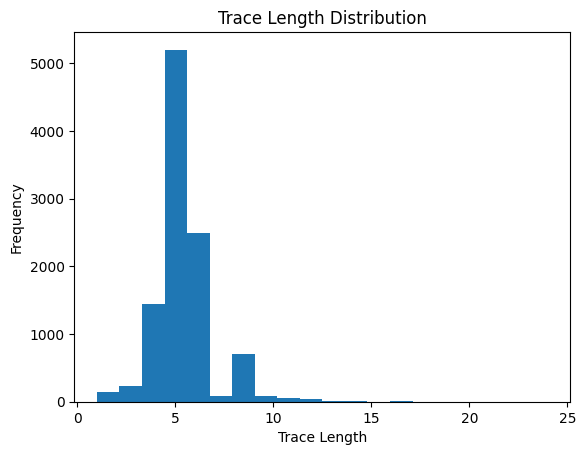

In [10]:
# average trace length
trace_lengths = [len(trace) for trace in trace_per_case]
print(f'Average trace length: {np.mean(trace_lengths)}')
# trace length distribution
plt.hist(trace_lengths, bins=20)
plt.xlabel('Trace Length')
plt.ylabel('Frequency')
plt.title('Trace Length Distribution')
plt.show()

In [11]:
# exclude traces with length 1 and bigger than 10
log = log[log["case:concept:name"].isin(trace_per_case[trace_per_case.apply(len) > 1].index)]
log = log[log["case:concept:name"].isin(trace_per_case[trace_per_case.apply(len) <= 10].index)]

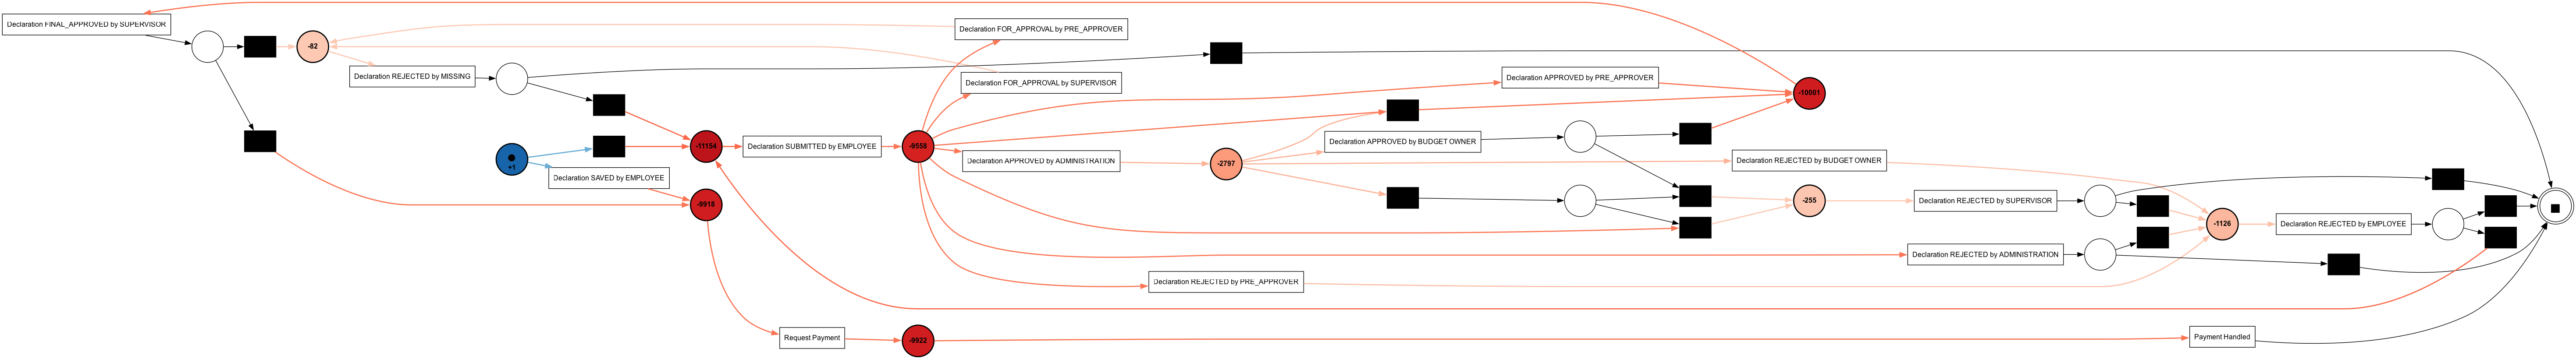

In [12]:
net, im, fm , graph = viz_petri_net(log)
visualizer.display(graph)

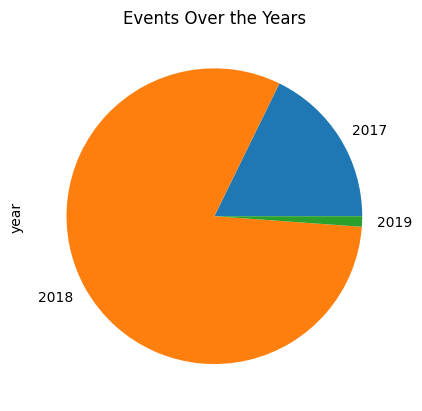

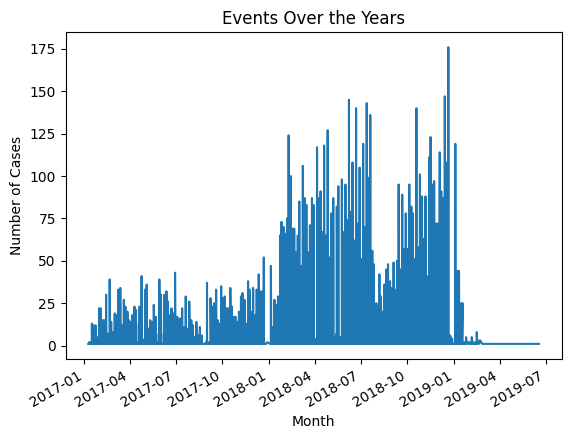

In [13]:
log["time:timestamp"] = pd.to_datetime(log["time:timestamp"])
log["year"] = log["time:timestamp"].dt.year
log["year"].value_counts().sort_index().plot(kind='pie')
plt.title('Events Over the Years')
plt.show()

log["time:timestamp"].value_counts().sort_index().plot(kind='line')
plt.xlabel('Month')
plt.ylabel('Number of Cases')
plt.title('Events Over the Years')
plt.show()

In [14]:
# split log according to cases started before and after 2018
log['start_year'] = log.groupby('case:concept:name')['time:timestamp'].transform('min').dt.year

log_before_2018 = log[log['start_year'] < 2018]
log_2018_and_after = log[log['start_year'] >= 2018]

LOGS = {
    'all': log,
    'before2018': log_before_2018,
    'after2018': log_2018_and_after
}

In [15]:
# split log according to years
for year, year_log in LOGS.items():
    print(f'{year}')
    print(f'Number of events: {year_log.shape[0]}')
    print(f'Number of cases: {year_log["case:concept:name"].unique().shape[0]}')
    print(f'Number of activities: {year_log["concept:name"].unique().shape[0]}')
    print(f'Number of traces: {year_log.groupby("case:concept:name")["concept:name"].aggregate(lambda x: tuple(x)).unique().shape[0]}')
    print()

all
Number of events: 54816
Number of cases: 10244
Number of activities: 16
Number of traces: 68

before2018
Number of events: 9901
Number of cases: 2195
Number of activities: 15
Number of traces: 34

after2018
Number of events: 44915
Number of cases: 8049
Number of activities: 10
Number of traces: 38



## Hyperparameter Tuning

### All Years

In [16]:
log = LOGS['all']
log = sample_log(log, sample_size=1000)

ids, traces = get_traces_from_log(log)
graph = create_graph(log)
graph, mapped_traces = apply_mapping(graph, traces)

In [17]:
configspace = get_configuration_space()
scenario = Scenario(configspace, n_trials=200)  

initial_design = HyperparameterOptimizationFacade.get_initial_design(scenario, n_configs=5)
smac = HyperparameterOptimizationFacade(
    scenario, 
    train,
    initial_design=initial_design,
    callbacks=[CustomCallback(n_trials=scenario.n_trials)],
    logging_level=999999,
    overwrite=True
)

incumbent = smac.optimize()
default_cost = smac.validate(configspace.get_default_configuration())
incumbent_cost = smac.validate(incumbent)

Let's start!

Current incumbent: {'dimensions': 8, 'epochs': 7, 'learning_rate': 0.019675709353759886, 'linkage': 'ward', 'min_count': 5, 'n_clusters': 6, 'type': 'edge', 'walk_length': 100, 'walk_number': 20, 'window_size': 8}
Current incumbent value: 0.1865781414291824

Evaluated 5 trials so far.
Current incumbent: {'dimensions': 8, 'epochs': 7, 'learning_rate': 0.019675709353759886, 'linkage': 'ward', 'min_count': 5, 'n_clusters': 6, 'type': 'edge', 'walk_length': 100, 'walk_number': 20, 'window_size': 8}
Current incumbent value: 0.18077544647272084

Evaluated 10 trials so far.
Current incumbent: {'dimensions': 32, 'epochs': 8, 'learning_rate': 0.035384302148595455, 'linkage': 'ward', 'min_count': 1, 'n_clusters': 9, 'type': 'edge', 'walk_length': 20, 'walk_number': 10, 'window_size': 2}
Current incumbent value: 0.16680871955077303

Evaluated 15 trials so far.
Current incumbent: {'dimensions': 32, 'epochs': 8, 'learning_rate': 0.035384302148595455, 'linkage': 'ward', 'min_count': 1,

In [18]:
print(f'============ ALL YEARS Default Configuration Cost: {default_cost} =================')
print(f'============ ALL YEARS Incumbent Configuration Cost: {incumbent_cost} =================')

============ ALL YEARS Default Configuration Cost: 0.188293890613742 =================
============ ALL YEARS Incumbent Configuration Cost: 0.1514576740648127 =================


In [19]:
print("============ ALL YEARS Best Configuration ============")
incumbent.get_dictionary()

============ ALL YEARS Best Configuration ============


{'dimensions': 32,
 'epochs': 8,
 'learning_rate': 0.021732631701323536,
 'linkage': 'ward',
 'min_count': 4,
 'n_clusters': 6,
 'type': 'node',
 'walk_length': 20,
 'walk_number': 20,
 'window_size': 4}

=== Cluster 0: 1043 events, 288 cases ===


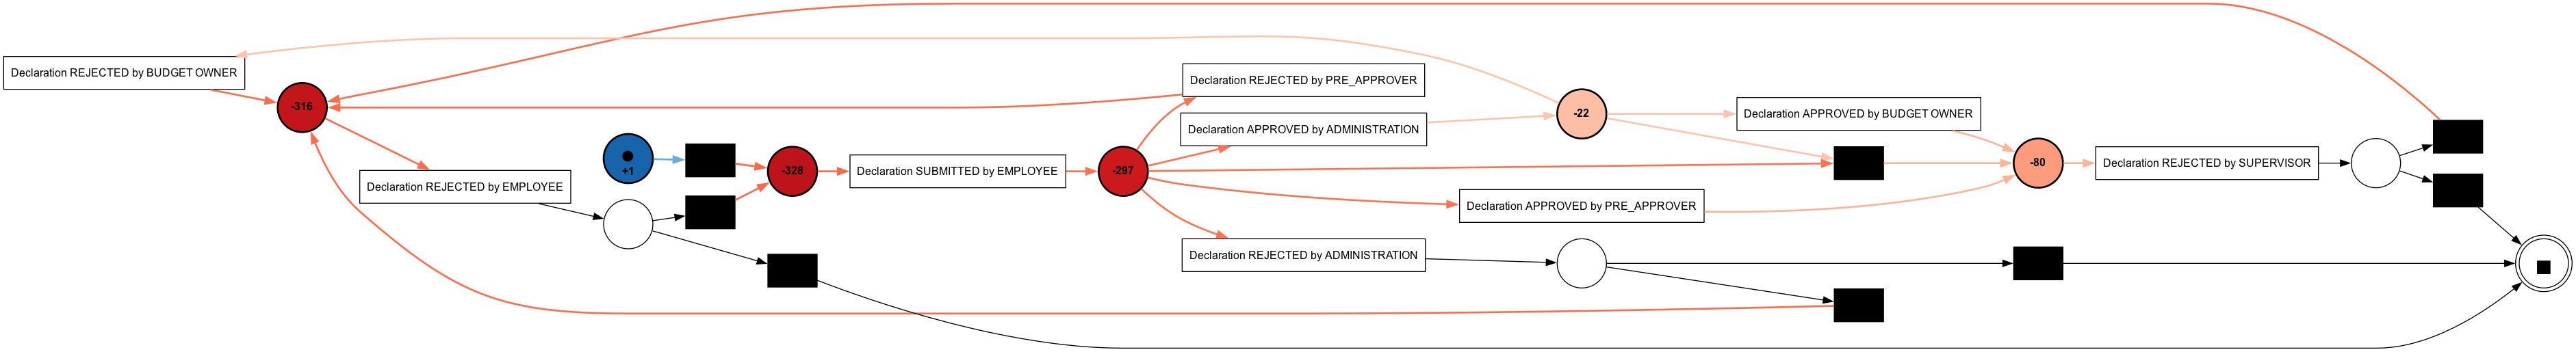

=== Cluster 1: 6044 events, 1472 cases ===


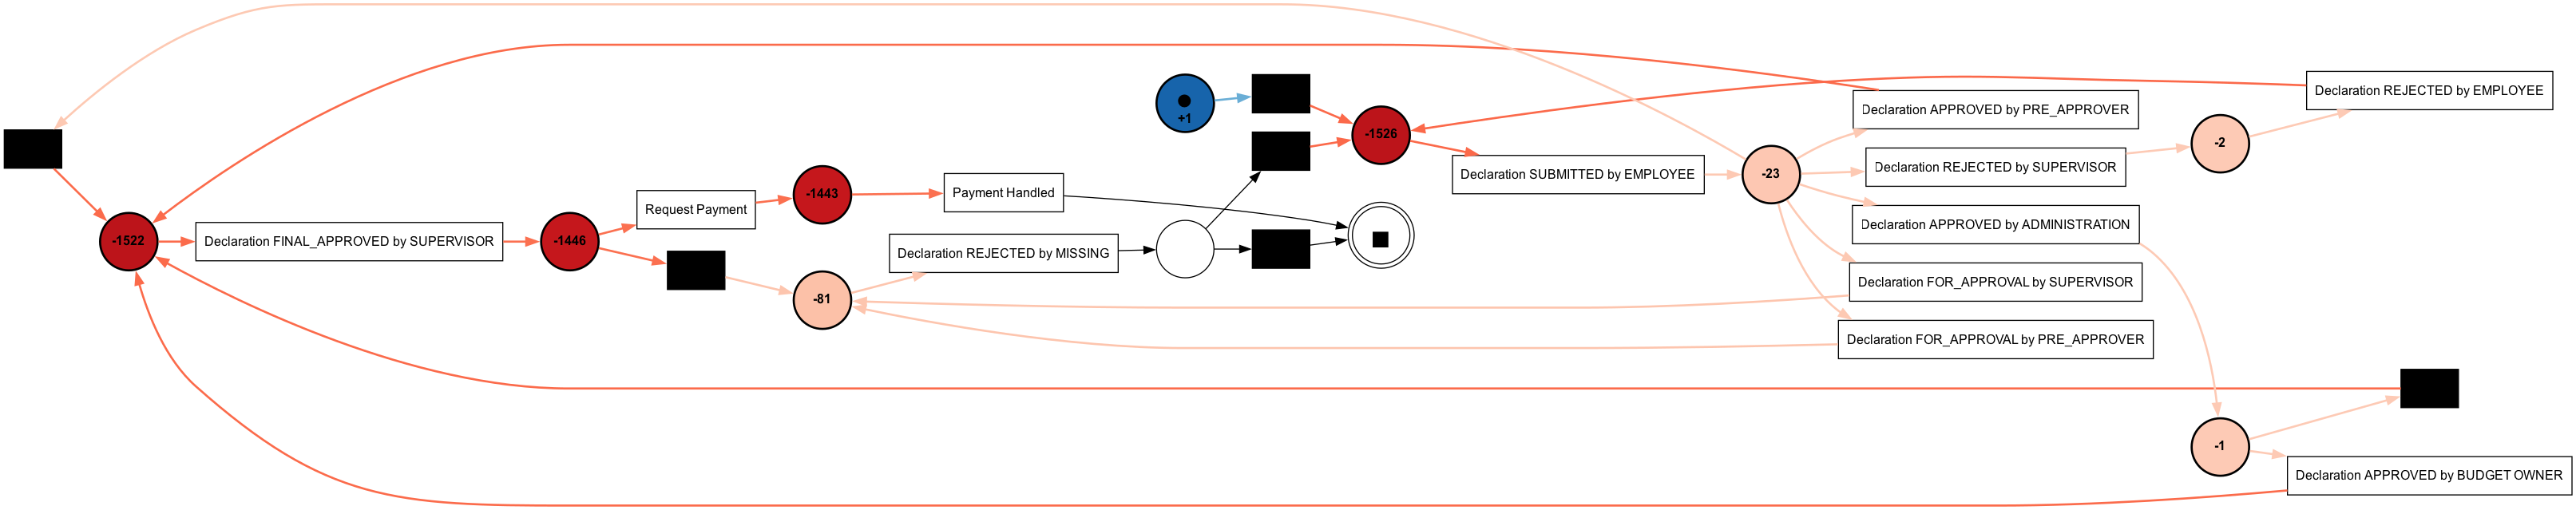

=== Cluster 2: 2878 events, 576 cases ===


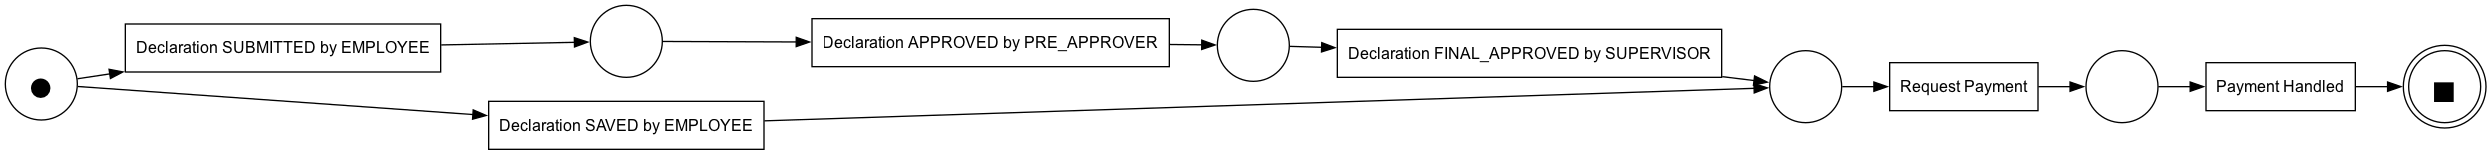

=== Cluster 3: 6923 events, 817 cases ===


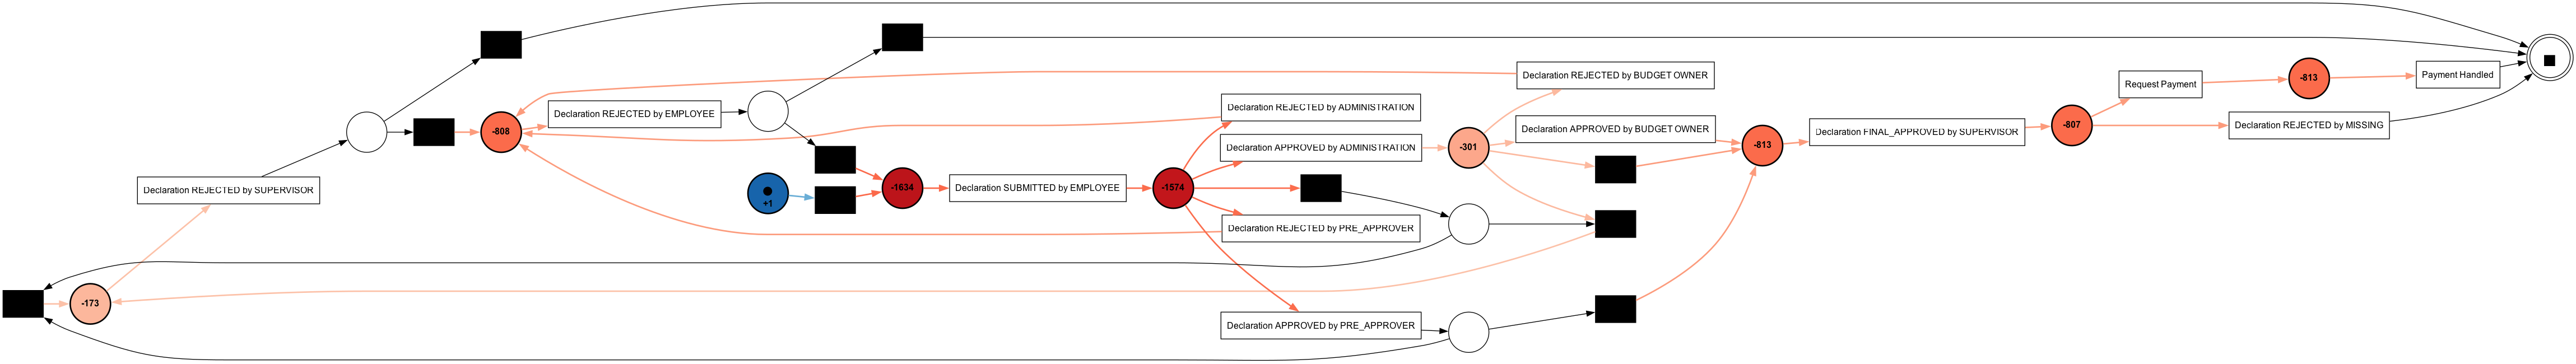

=== Cluster 4: 23090 events, 4618 cases ===


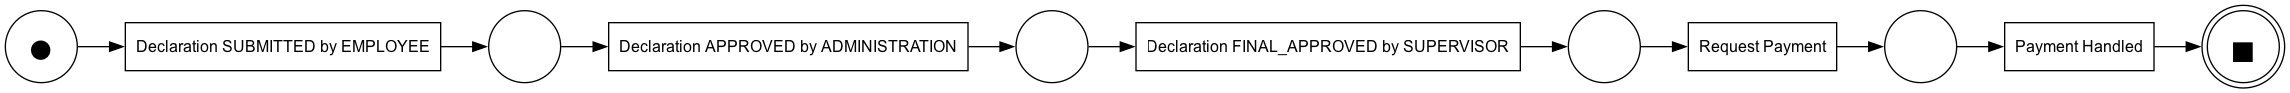

=== Cluster 5: 14838 events, 2473 cases ===


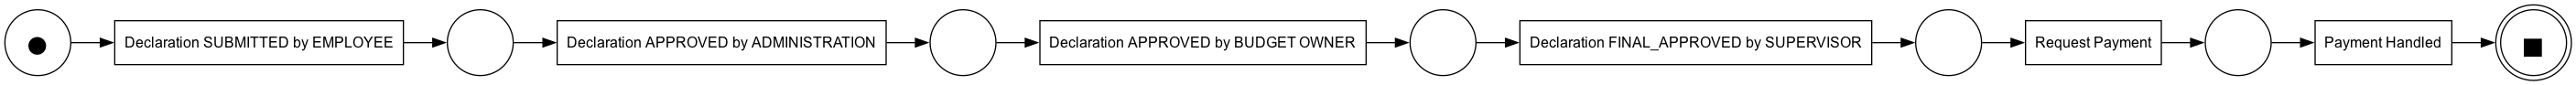

=== Process Model Scores ===
          fitness  precision  generalization  simplicity  log_length    custom
Cluster                                                                       
0        0.958663   0.981413        0.717952    0.627907      1043.0  0.957520
1        0.999709   0.915427        0.607236    0.674419      6044.0  0.944686
2        1.000000   1.000000        0.798593    1.000000      2878.0  0.974360
3        0.956301   0.866388        0.744811    0.627119      6923.0  0.916671
4        1.000000   1.000000        0.985285    1.000000     23090.0  0.974360
5        1.000000   1.000000        0.979891    1.000000     14838.0  0.974360
=== Weighted Average Process Model Scores ===
fitness           0.993662
precision         0.973447
generalization    0.896882
simplicity        0.909928
custom            0.963482
dtype: float64
=== Clustering Scores ===
Silhouette Score: 0.935899019241333
Custom Metric: 0.9634815872650769


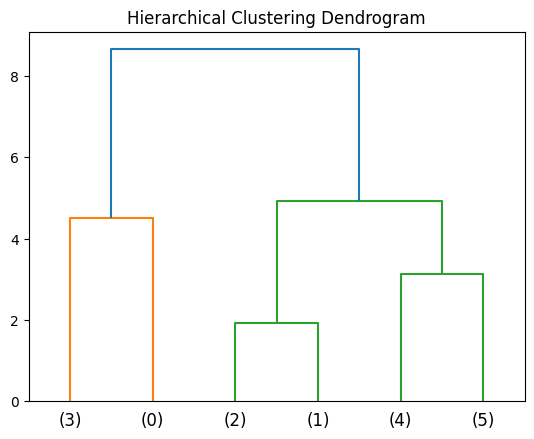

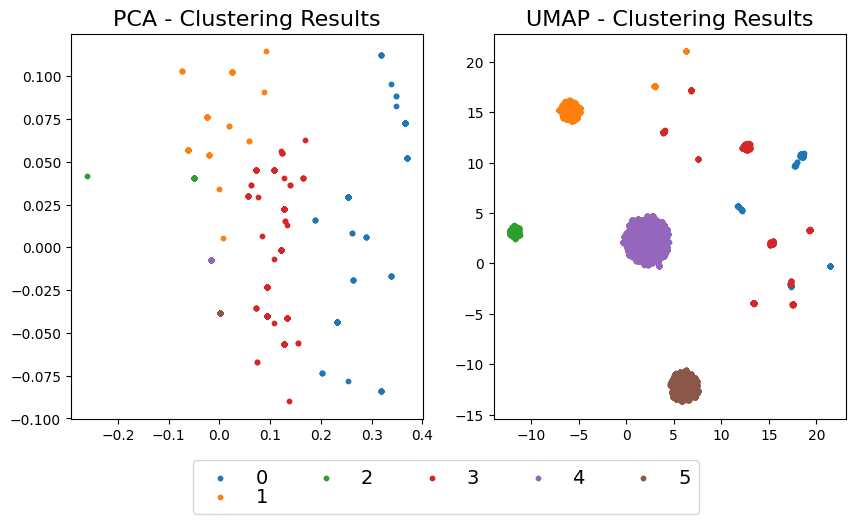

In [20]:
# final models
log = LOGS['all']
ids, traces = get_traces_from_log(log)
graph = create_graph(log)
graph, mapped_traces = apply_mapping(graph, traces)

config_dict = incumbent.get_dictionary()
if config_dict["type"] == "node":
    vectors = generate_walklets_node_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
             seed=42)
else:
    vectors = generate_walklets_edge_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
             seed=42)
encoding_df = get_encoding_df(vectors, ids)
clusters = cluster_data_hierarchical(encoding_df, n_clusters=config_dict["n_clusters"], metric=config_dict.get("metric", "euclidean"), linkage=config_dict["linkage"])
clustered_logs = split_log_by_clusters(add_clusters_to_log(log, encoding_df, clusters))
mine_petri_nets(clustered_logs, encoding_df.iloc[:, 1:], clusters, name="All Years")
plot_dendrogram(encoding_df.iloc[:, 1:], incumbent, clusters)
plot_dimension_reduction(encoding_df.iloc[:, 1:], clusters)

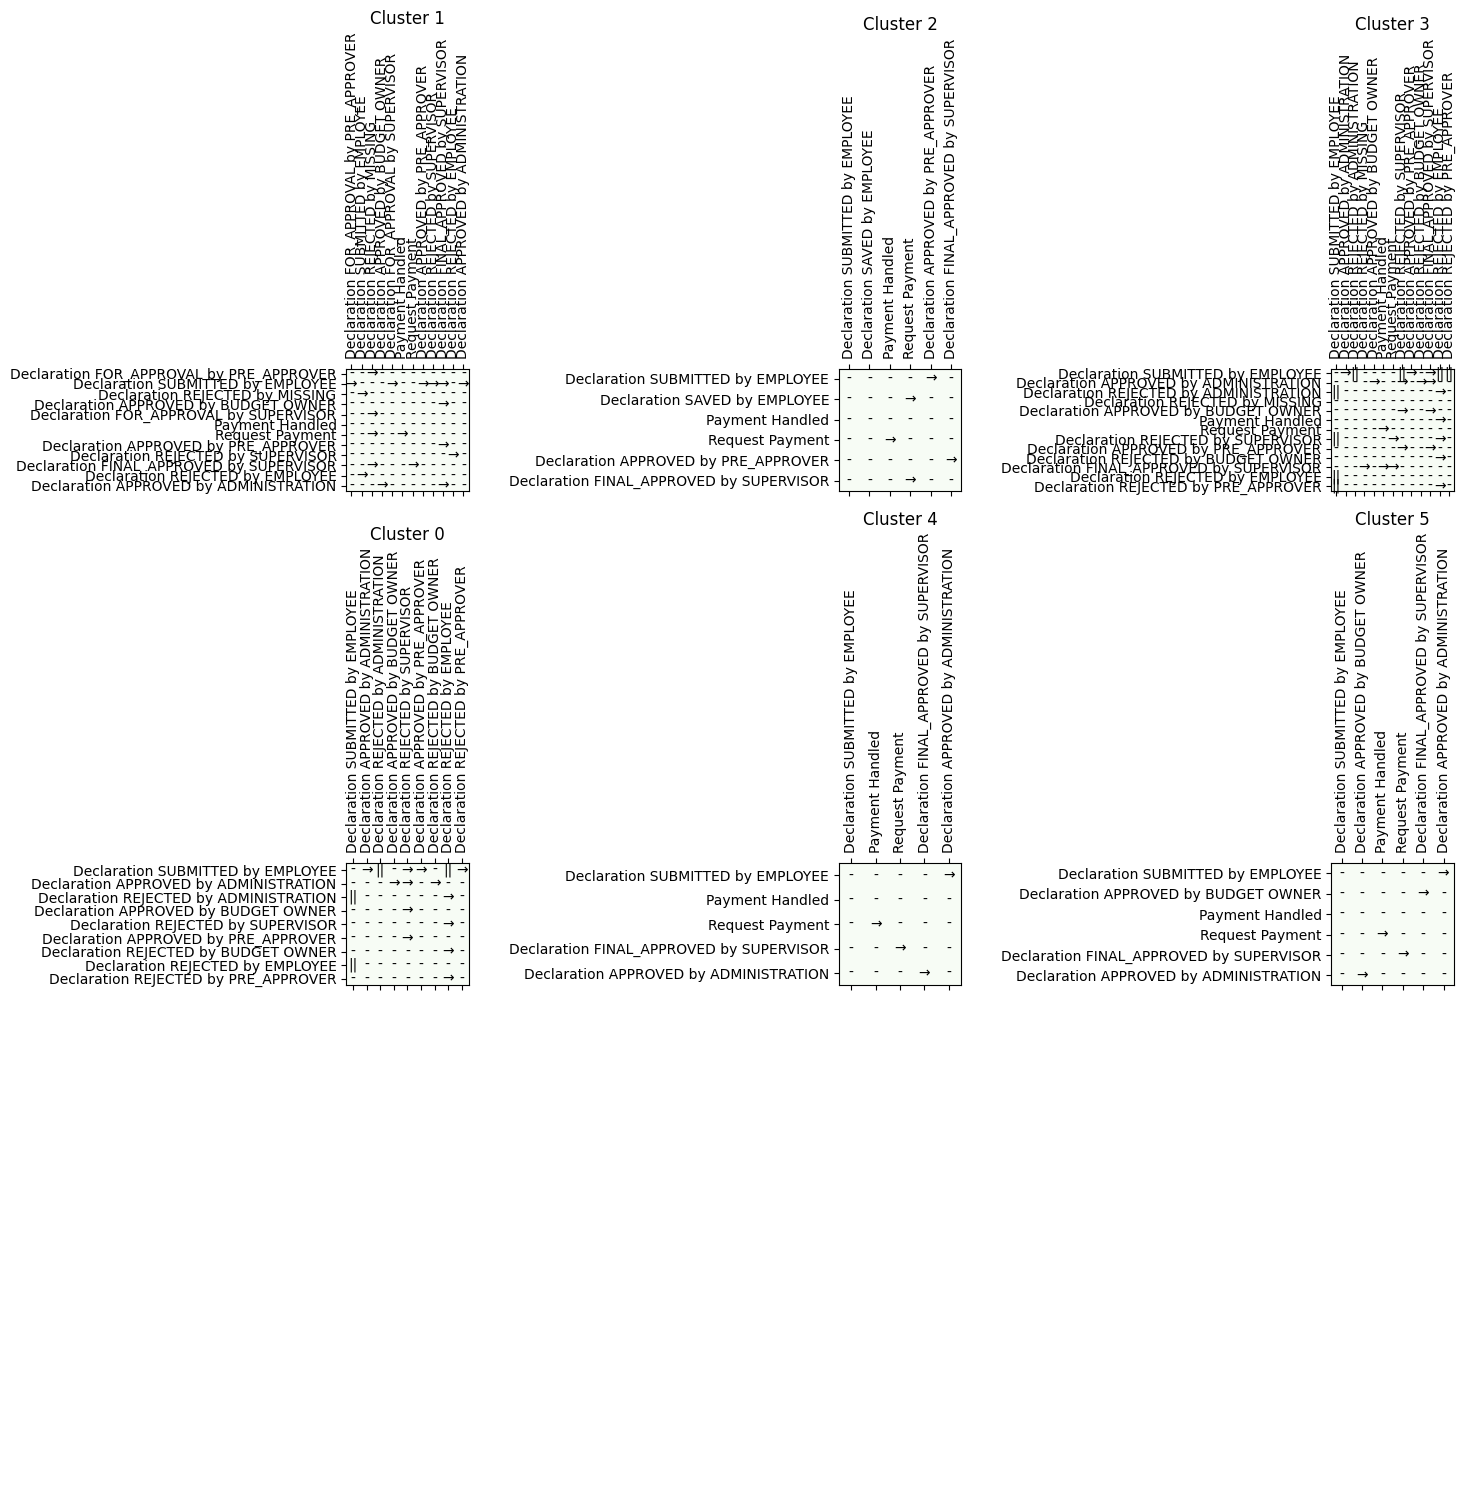

In [21]:
footprint_matrix(clustered_logs)

In [22]:
# export sublogs
export_sublogs_to_csv(clustered_logs, folder="advanced_approach")

Clusters exported to /advanced_approach


### Before 2018

In [23]:
log = LOGS['before2018']
log = sample_log(log, sample_size=1000)

ids, traces = get_traces_from_log(log)
graph = create_graph(log)
graph, mapped_traces = apply_mapping(graph, traces)

In [24]:
configspace = get_configuration_space()
scenario = Scenario(configspace, n_trials=200)  

initial_design = HyperparameterOptimizationFacade.get_initial_design(scenario, n_configs=5)
smac = HyperparameterOptimizationFacade(
    scenario, 
    train,
    initial_design=initial_design,
    callbacks=[CustomCallback(n_trials=scenario.n_trials)],
    logging_level=999999,
    overwrite=True
)

incumbent = smac.optimize()
default_cost = smac.validate(configspace.get_default_configuration())
incumbent_cost = smac.validate(incumbent)

Let's start!

Current incumbent: {'dimensions': 8, 'epochs': 7, 'learning_rate': 0.019675709353759886, 'linkage': 'ward', 'min_count': 5, 'n_clusters': 6, 'type': 'edge', 'walk_length': 100, 'walk_number': 20, 'window_size': 8}
Current incumbent value: 0.1398867132611593

Evaluated 5 trials so far.
Current incumbent: {'dimensions': 8, 'epochs': 7, 'learning_rate': 0.019675709353759886, 'linkage': 'ward', 'min_count': 5, 'n_clusters': 6, 'type': 'edge', 'walk_length': 100, 'walk_number': 20, 'window_size': 8}
Current incumbent value: 0.1411299526987828

Evaluated 10 trials so far.
Current incumbent: {'dimensions': 32, 'epochs': 8, 'learning_rate': 0.035384302148595455, 'linkage': 'ward', 'min_count': 1, 'n_clusters': 9, 'type': 'edge', 'walk_length': 20, 'walk_number': 10, 'window_size': 2}
Current incumbent value: 0.14055320275832375

Evaluated 15 trials so far.
Current incumbent: {'dimensions': 32, 'epochs': 8, 'learning_rate': 0.035384302148595455, 'linkage': 'ward', 'min_count': 1, 

In [25]:
print(f'============ BEFORE 2018 Default Configuration Cost: {default_cost} =================')
print(f'============ BEFORE 2018 Incumbent Configuration Cost: {incumbent_cost} =================')

============ BEFORE 2018 Default Configuration Cost: 0.12638128810520124 =================
============ BEFORE 2018 Incumbent Configuration Cost: 0.1288498026045551 =================


In [26]:
print("============ BEFORE 2018 Best Configuration ============")
incumbent.get_dictionary()

============ BEFORE 2018 Best Configuration ============


{'dimensions': 64,
 'epochs': 6,
 'learning_rate': 0.010787060699618116,
 'linkage': 'ward',
 'min_count': 3,
 'n_clusters': 6,
 'type': 'node',
 'walk_length': 86,
 'walk_number': 20,
 'window_size': 2}

=== Cluster 0: 5571 events, 1393 cases ===


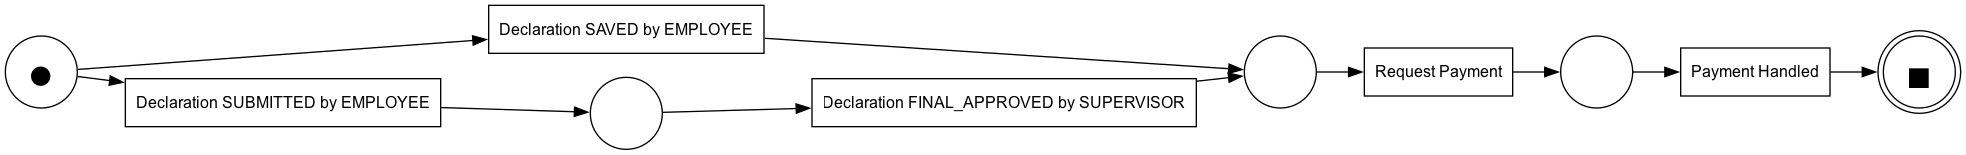

=== Cluster 1: 133 events, 36 cases ===


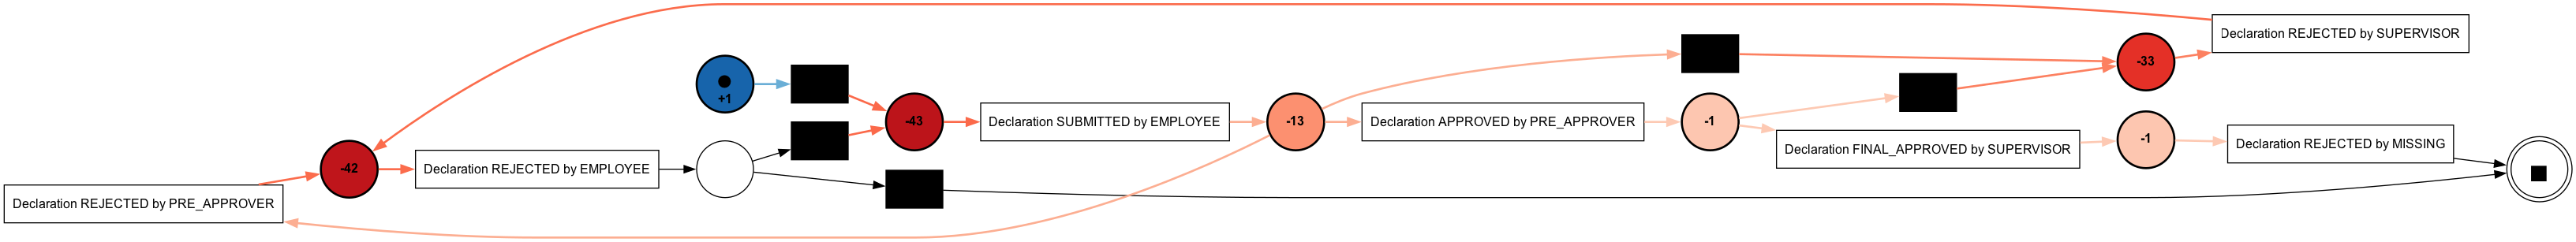

=== Cluster 2: 419 events, 61 cases ===


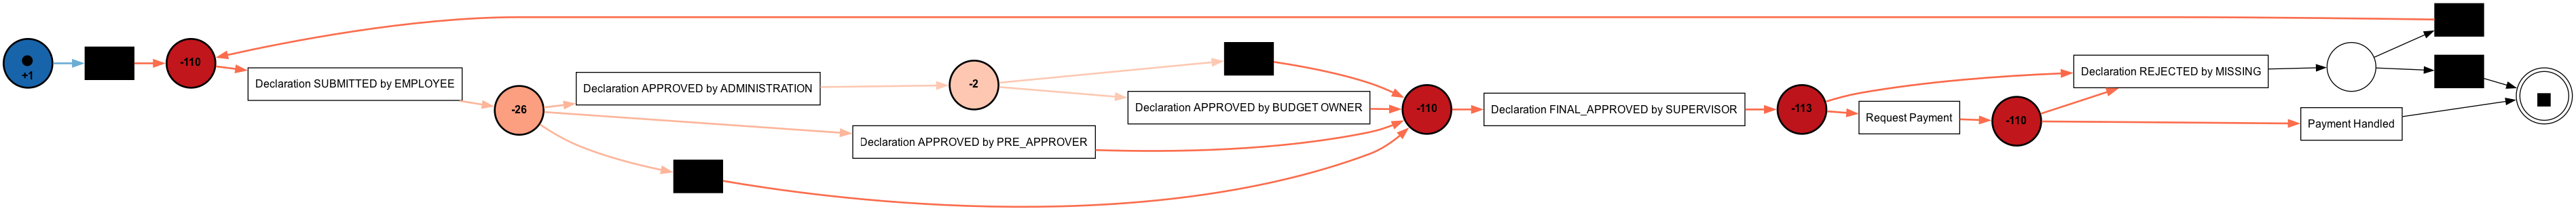

=== Cluster 3: 83 events, 26 cases ===


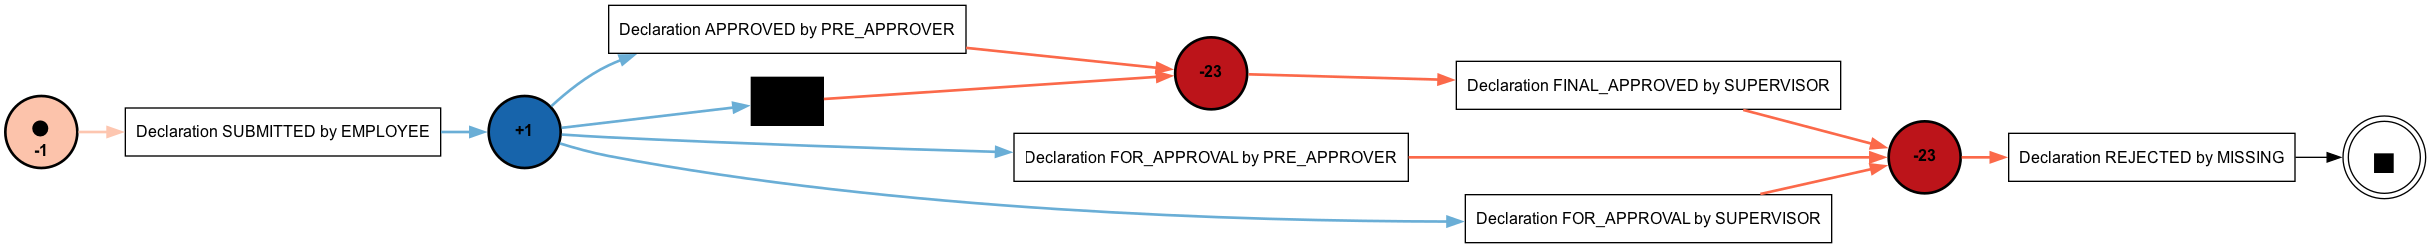

=== Cluster 4: 820 events, 104 cases ===


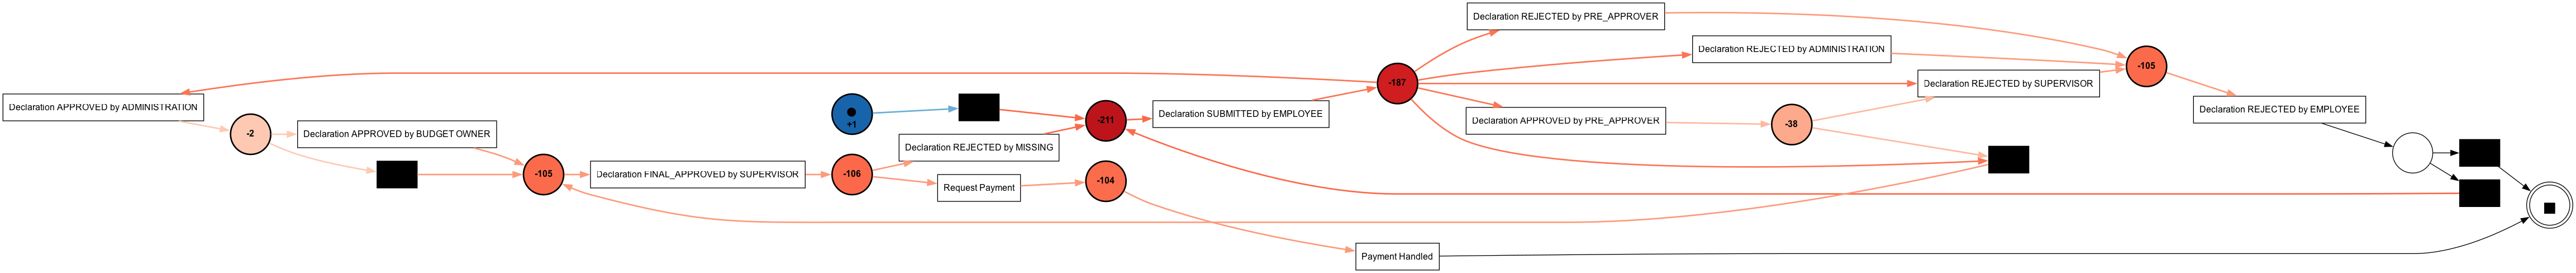

=== Cluster 5: 2875 events, 575 cases ===


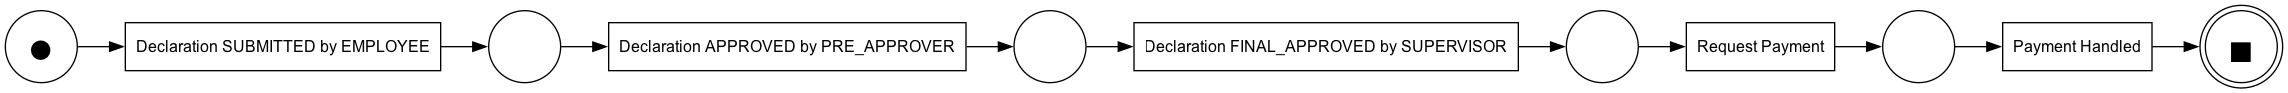

=== Process Model Scores ===
          fitness  precision  generalization  simplicity  log_length    custom
Cluster                                                                       
0        1.000000   1.000000        0.778562    1.000000      5571.0  0.985046
1        1.000000   0.943750        0.601017    0.777778       133.0  0.965359
2        0.764776   0.984330        0.757984    0.687500       419.0  0.920756
3        0.987179   1.000000        0.499926    0.750000        83.0  0.981841
4        0.775422   0.851807        0.649530    0.636364       820.0  0.877034
5        1.000000   1.000000        0.958297    1.000000      2875.0  0.985046
=== Weighted Average Process Model Scores ===
fitness           0.971339
precision         0.986308
generalization    0.814474
simplicity        0.951578
custom            0.973089
dtype: float64
=== Clustering Scores ===
Silhouette Score: 0.9626156687736511
Custom Metric: 0.9730887072746617


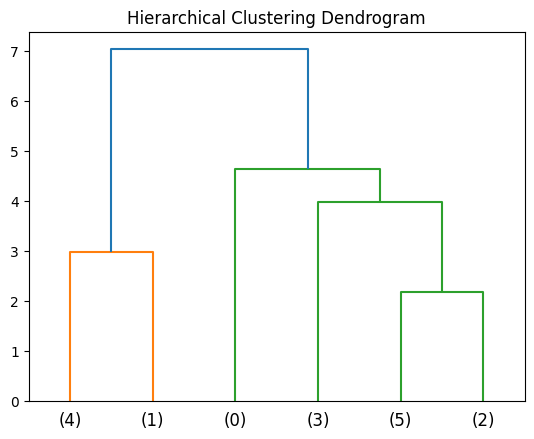

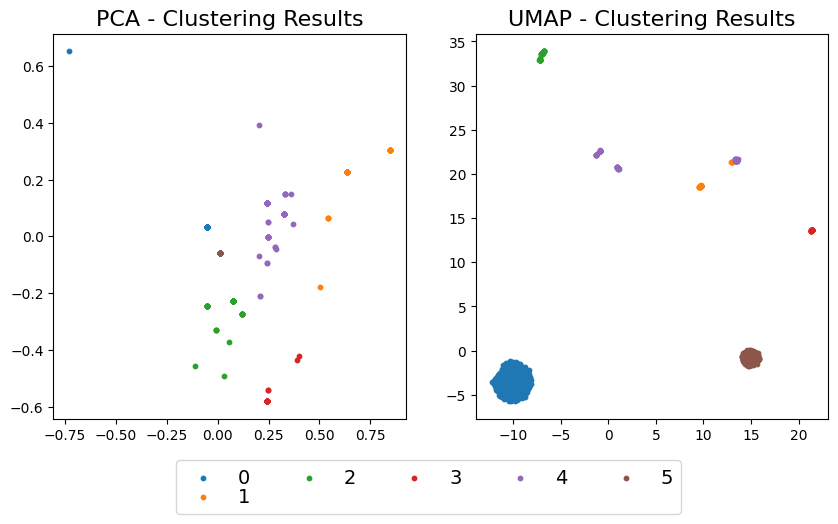

In [27]:
# final models
log = LOGS['before2018']
ids, traces = get_traces_from_log(log)
graph = create_graph(log)
graph, mapped_traces = apply_mapping(graph, traces)

config_dict = incumbent.get_dictionary()
if config_dict["type"] == "node":
    vectors = generate_walklets_node_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
             seed=42)
else:
    vectors = generate_walklets_edge_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
             seed=42)
encoding_df = get_encoding_df(vectors, ids)
clusters = cluster_data_hierarchical(encoding_df, n_clusters=config_dict["n_clusters"], metric=config_dict.get("metric", "euclidean"), linkage=config_dict["linkage"])
clustered_logs = split_log_by_clusters(add_clusters_to_log(log, encoding_df, clusters))
mine_petri_nets(clustered_logs, encoding_df.iloc[:, 1:], clusters, name="Before 2018")
plot_dendrogram(encoding_df.iloc[:, 1:], incumbent, clusters)
plot_dimension_reduction(encoding_df.iloc[:, 1:], clusters)

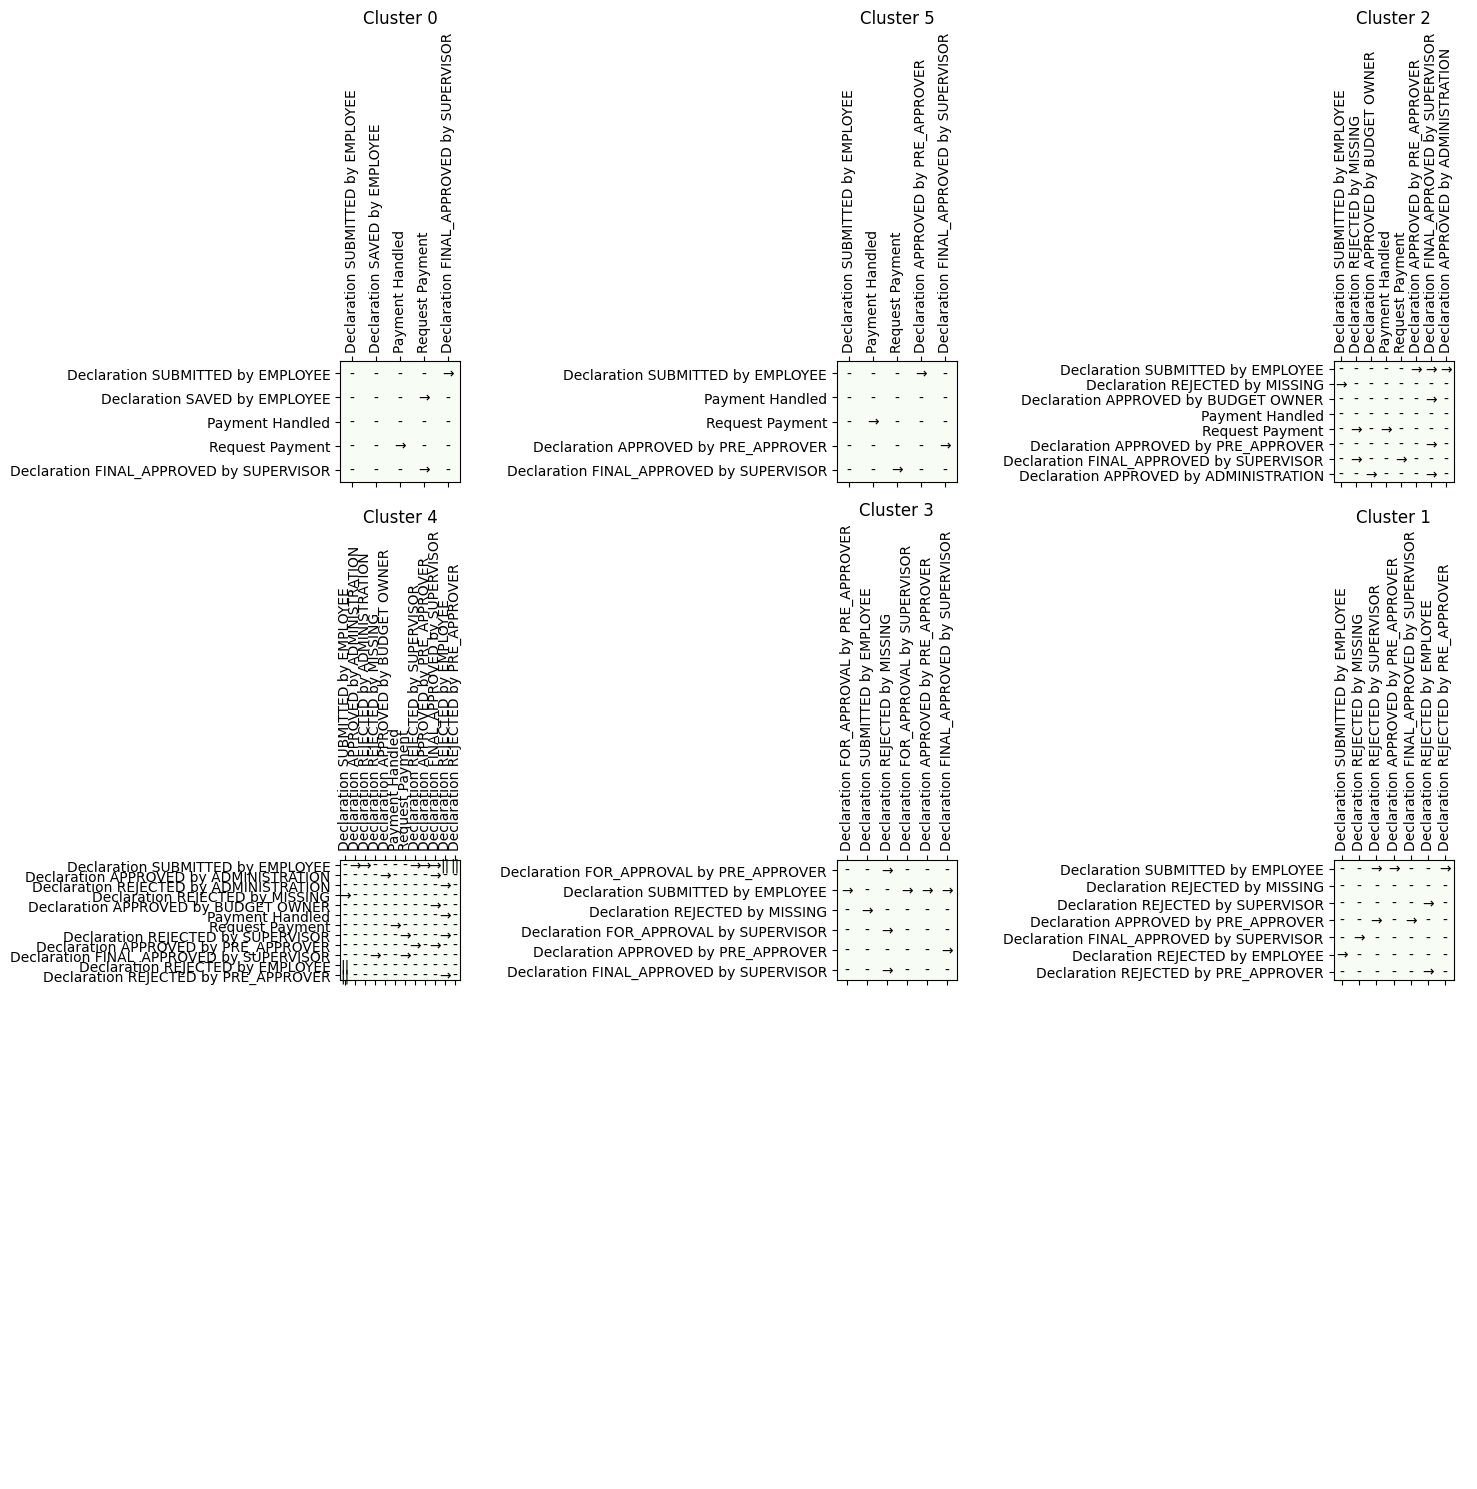

In [28]:
footprint_matrix(clustered_logs)

### After 2018

In [29]:
log = LOGS['after2018']
log = sample_log(log, sample_size=1000)

ids, traces = get_traces_from_log(log)
graph = create_graph(log)
graph, mapped_traces = apply_mapping(graph, traces)

In [30]:
configspace = get_configuration_space()
scenario = Scenario(configspace, n_trials=200)  

initial_design = HyperparameterOptimizationFacade.get_initial_design(scenario, n_configs=5)
smac = HyperparameterOptimizationFacade(
    scenario, 
    train,
    initial_design=initial_design,
    callbacks=[CustomCallback(n_trials=scenario.n_trials)],
    logging_level=999999,
    overwrite=True
)

incumbent = smac.optimize()
default_cost = smac.validate(configspace.get_default_configuration())
incumbent_cost = smac.validate(incumbent)

Let's start!

Current incumbent: {'dimensions': 8, 'epochs': 7, 'learning_rate': 0.019675709353759886, 'linkage': 'ward', 'min_count': 5, 'n_clusters': 6, 'type': 'edge', 'walk_length': 100, 'walk_number': 20, 'window_size': 8}
Current incumbent value: 0.09526904697419825

Evaluated 5 trials so far.
Current incumbent: {'dimensions': 8, 'epochs': 7, 'learning_rate': 0.019675709353759886, 'linkage': 'ward', 'min_count': 5, 'n_clusters': 6, 'type': 'edge', 'walk_length': 100, 'walk_number': 20, 'window_size': 8}
Current incumbent value: 0.09584157346913398

Evaluated 10 trials so far.
Current incumbent: {'dimensions': 32, 'epochs': 8, 'learning_rate': 0.035384302148595455, 'linkage': 'ward', 'min_count': 1, 'n_clusters': 9, 'type': 'edge', 'walk_length': 20, 'walk_number': 10, 'window_size': 2}
Current incumbent value: 0.08955257885132169

Evaluated 15 trials so far.
Current incumbent: {'dimensions': 32, 'epochs': 8, 'learning_rate': 0.035384302148595455, 'linkage': 'ward', 'min_count': 1

In [31]:
print(f'============ AFTER 2018 Default Configuration Cost: {default_cost} =================')
print(f'============ AFTER 2018 Incumbent Configuration Cost: {incumbent_cost} =================')

============ AFTER 2018 Default Configuration Cost: 0.0902486065768117 =================
============ AFTER 2018 Incumbent Configuration Cost: 0.08059247109784007 =================


In [32]:
print("============ AFTER 2018 Best Configuration ============")
incumbent.get_dictionary()

============ AFTER 2018 Best Configuration ============


{'dimensions': 128,
 'epochs': 9,
 'learning_rate': 0.051013598711603374,
 'linkage': 'ward',
 'min_count': 1,
 'n_clusters': 5,
 'type': 'node',
 'walk_length': 54,
 'walk_number': 5,
 'window_size': 4}

=== Cluster 0: 6080 events, 705 cases ===


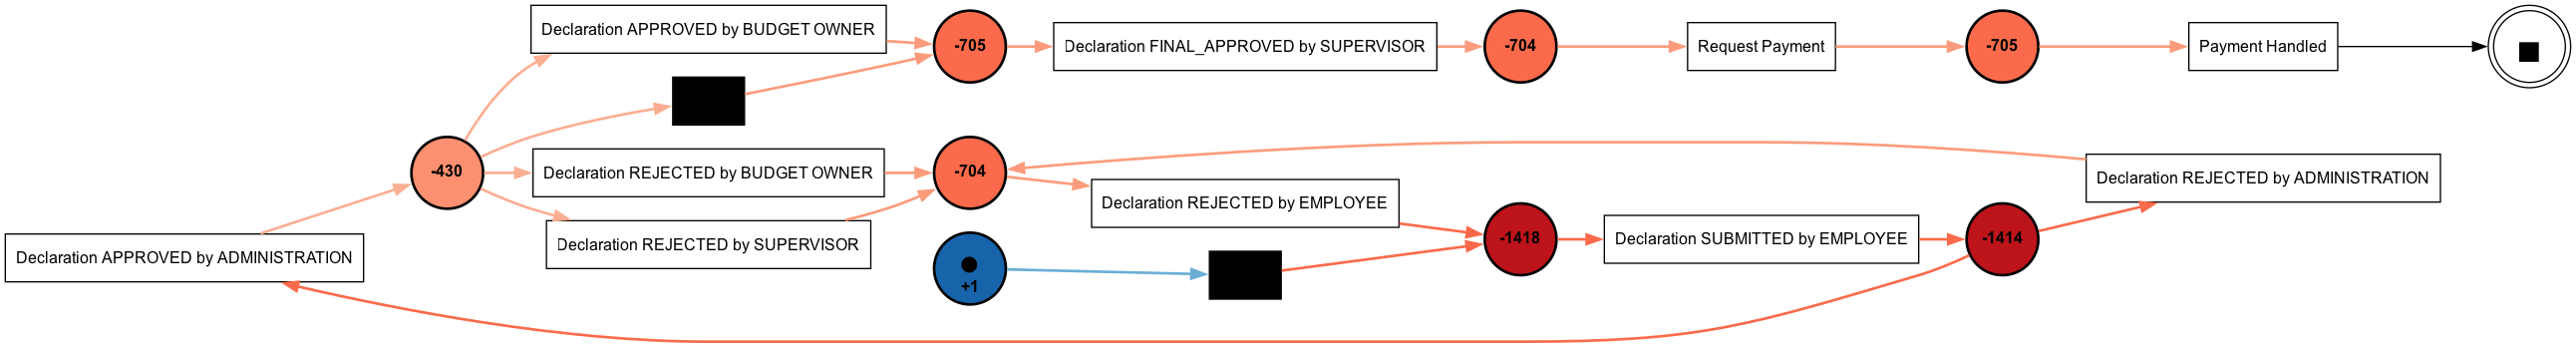

=== Cluster 1: 14858 events, 2478 cases ===


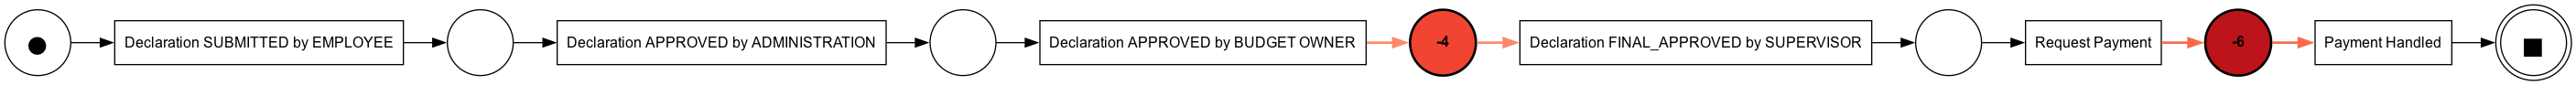

=== Cluster 2: 305 events, 62 cases ===


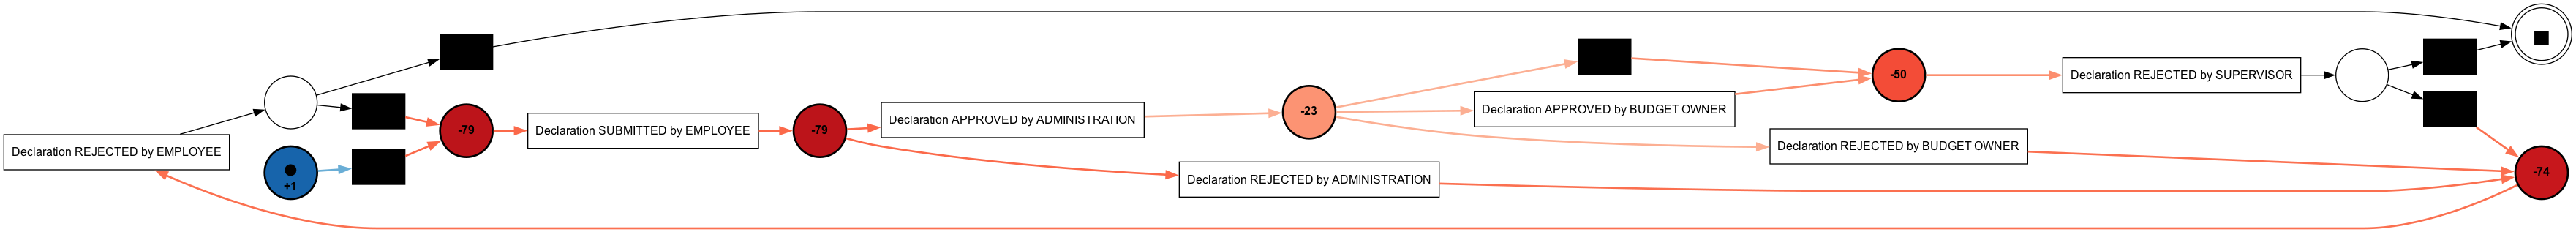

=== Cluster 3: 23050 events, 4610 cases ===


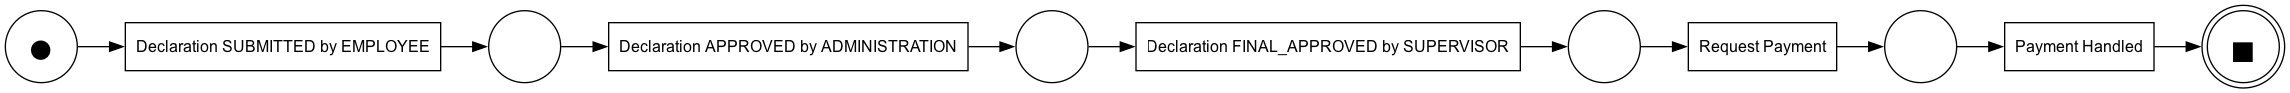

=== Cluster 4: 622 events, 194 cases ===


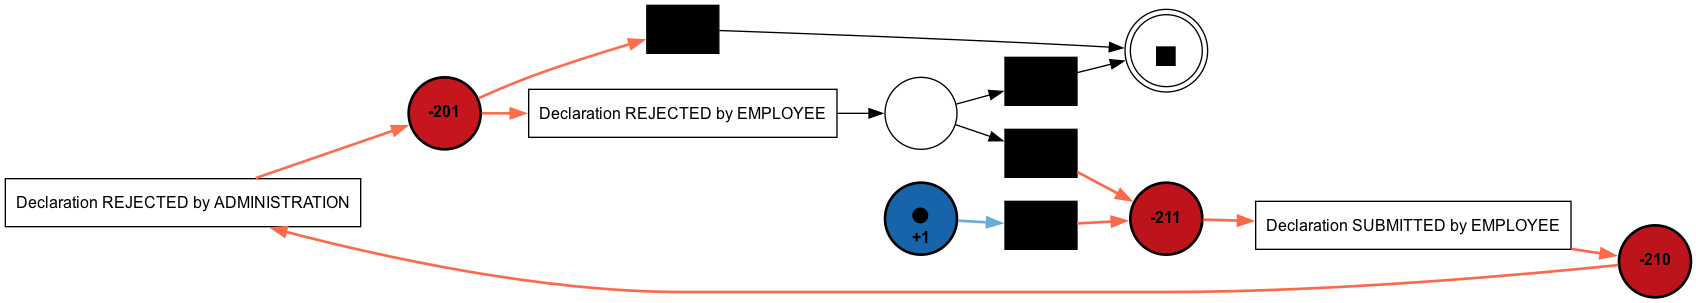

=== Process Model Scores ===
          fitness  precision  generalization  simplicity  log_length    custom
Cluster                                                                       
0        0.998426   0.888172        0.945089    0.777778      6080.0  0.956117
1        0.999604   1.000000        0.979905    1.000000     14858.0  0.995552
2        0.998208   0.983979        0.794806    0.733333       305.0  0.989595
3        1.000000   1.000000        0.985272    1.000000     23050.0  0.995651
4        0.996809   1.000000        0.857753    0.866667       622.0  0.994853
=== Weighted Average Process Model Scores ===
fitness           0.999600
precision         0.984753
generalization    0.974998
simplicity        0.966261
custom            0.990214
dtype: float64
=== Clustering Scores ===
Silhouette Score: 0.989126443862915
Custom Metric: 0.9902141350706956


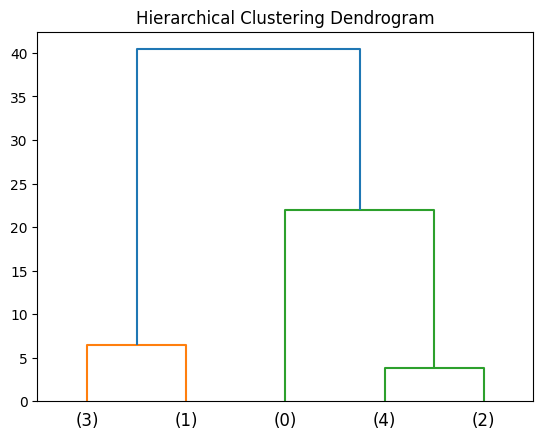

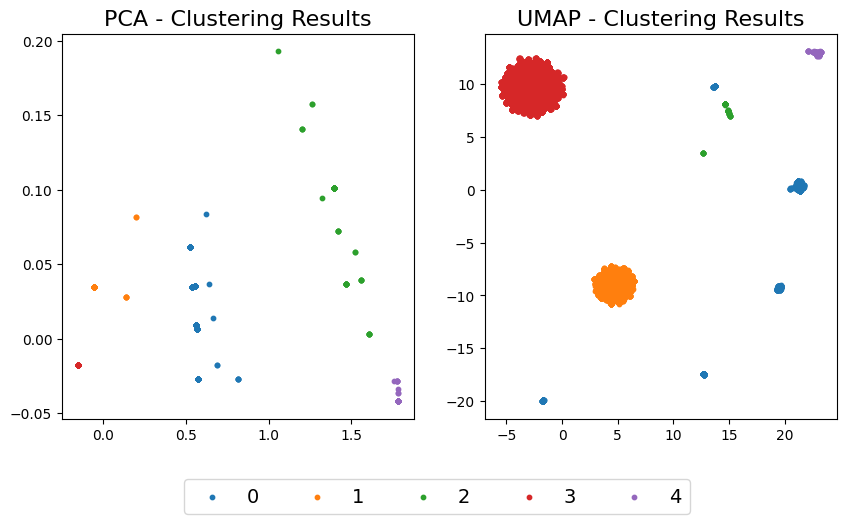

In [33]:
# final models
log = LOGS['after2018']
ids, traces = get_traces_from_log(log)
graph = create_graph(log)
graph, mapped_traces = apply_mapping(graph, traces)

config_dict = incumbent.get_dictionary()
if config_dict["type"] == "node":
    vectors = generate_walklets_node_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
             seed=42)
else:
    vectors = generate_walklets_edge_embeddings(graph, mapped_traces, walk_number=config_dict["walk_number"], walk_length=config_dict["walk_length"], dimensions=config_dict["dimensions"], window_size=config_dict["window_size"], epochs=config_dict["epochs"], workers=8,learning_rate=config_dict["learning_rate"], min_count=config_dict["min_count"],
             seed=42)
encoding_df = get_encoding_df(vectors, ids)
clusters = cluster_data_hierarchical(encoding_df, n_clusters=config_dict["n_clusters"], metric=config_dict.get("metric", "euclidean"), linkage=config_dict["linkage"])
clustered_logs = split_log_by_clusters(add_clusters_to_log(log, encoding_df, clusters))
mine_petri_nets(clustered_logs, encoding_df.iloc[:, 1:], clusters, name="After 2018")
plot_dendrogram(encoding_df.iloc[:, 1:], incumbent, clusters)
plot_dimension_reduction(encoding_df.iloc[:, 1:], clusters)

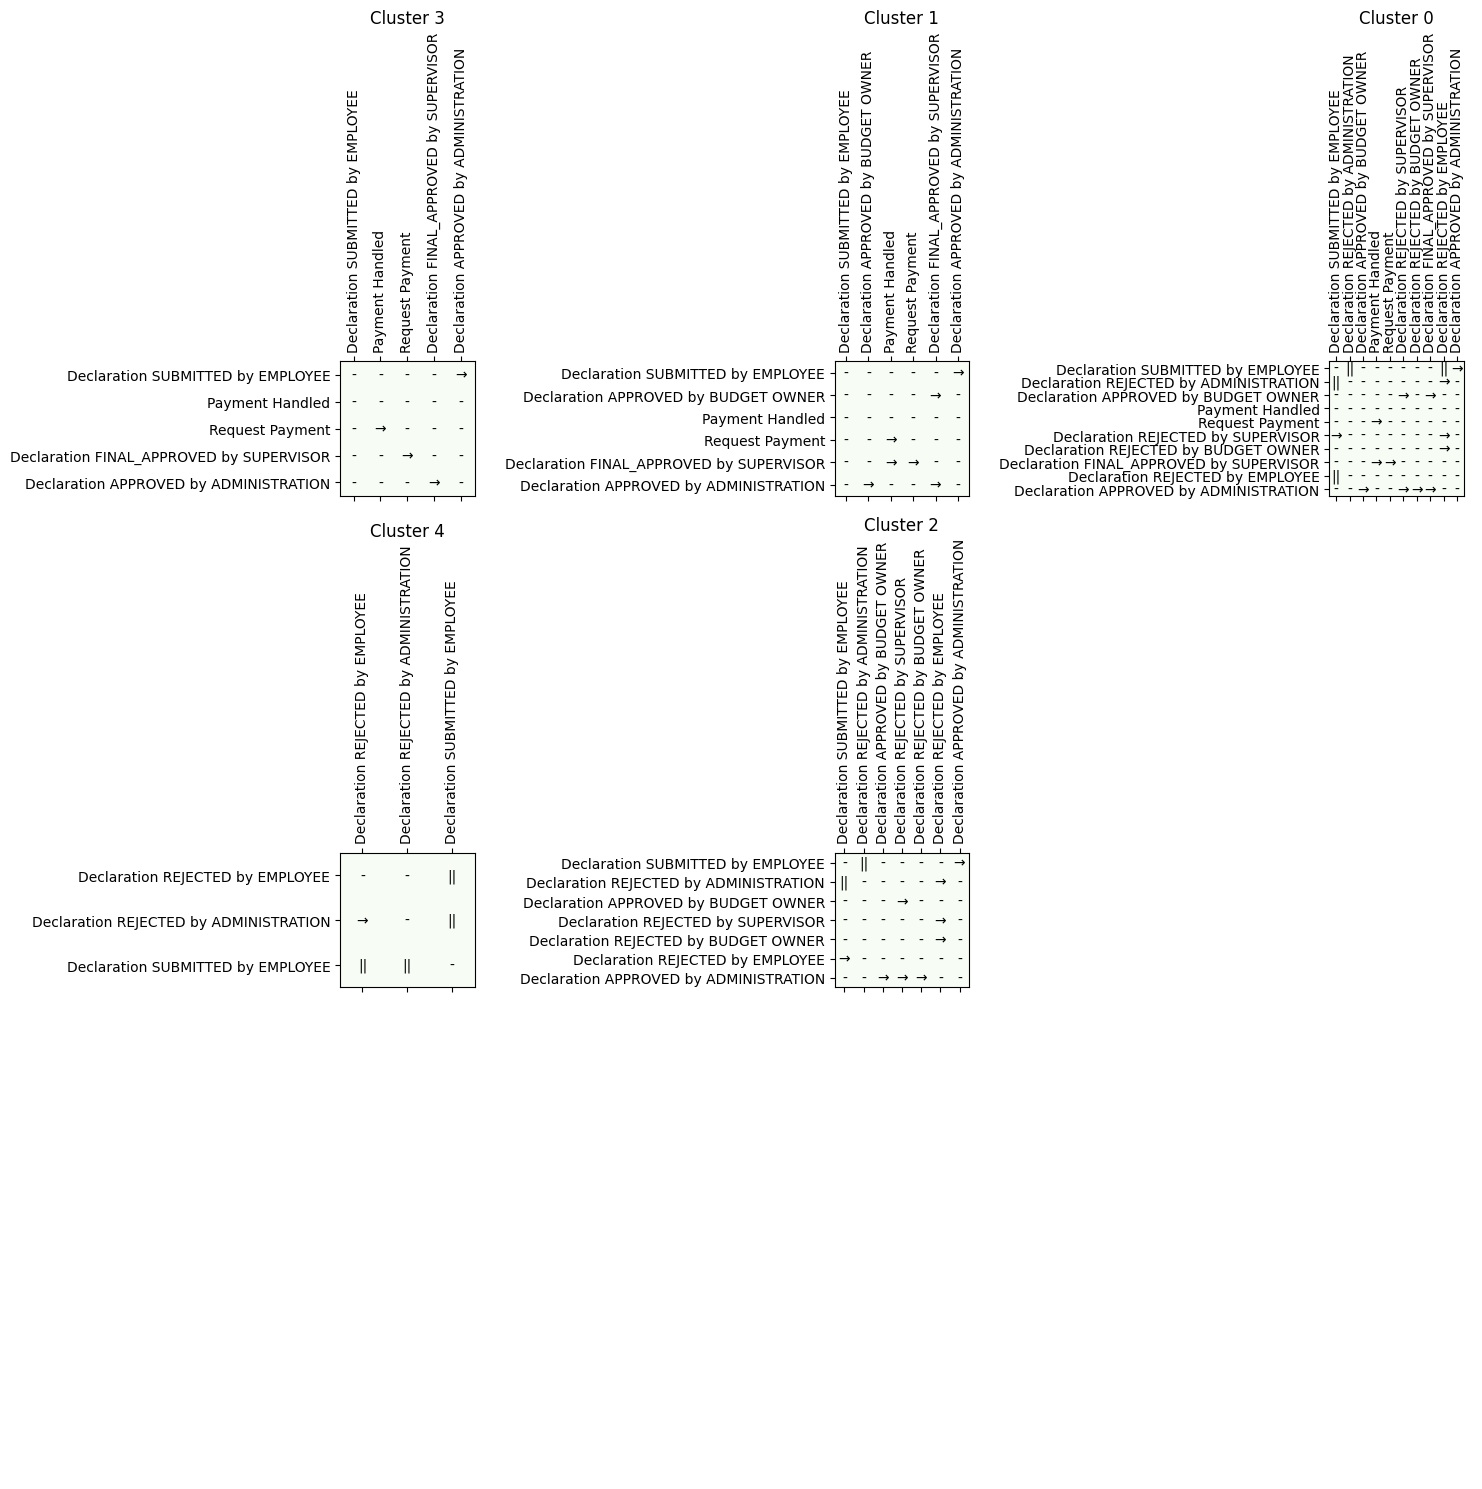

In [34]:
footprint_matrix(clustered_logs)

## Results

In [35]:
experiment_results_df = pd.DataFrame(experiment_results).T
experiment_results_df

,fitness,precision,generalization,simplicity,custom
All Years,0.993662,0.973447,0.896882,0.909928,0.963482
Before 2018,0.971339,0.986308,0.814474,0.951578,0.973089
After 2018,0.999600,0.984753,0.974998,0.966261,0.990214
